# Sentiment analysis on forum articles using word2vec and Keras

참고: http://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

원문과 달리 감정 분석이 아닌 정치글이냐 아니냐를 판별하는 분류기를 만든다. 1이면 정치글, 0이면 아닌글이다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions

In [2]:
pd.options.mode.chained_assignment = None
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


데이타는 커뮤니티 게시글의 형태소 분석 결과 중 명사를 정리한 결과로 한다.  
커뮤니티 게시글인 관계로 비문이 많이 섞여 있는 편이다.

참고: http://docs.likejazz.com/cnn-text-classification-tf/

In [3]:
data = pd.read_csv('data/news-title-class.csv')

data.head(5)

,SentimentText,Sentiment
0,0 1 공통점,0
1,0 국어 구사 아이돌,0
2,04 도깨비 은탁 엔딩 사랑 물리학,0
3,1 1만 키로 정도,0
4,1 1박2일 2 정준영 등장 눈물 김종민,0


In [4]:
import nltk
# data['tokens'] = nltk.word_tokenize(data['SentimentText'])
data['tokens'] = ''
i = 0
for text in data['SentimentText']:
    data['tokens'][i] = nltk.word_tokenize(text)
    i += 1

data.head(5)

,SentimentText,Sentiment,tokens
0,0 1 공통점,0,"[0, 1, 공통점]"
1,0 국어 구사 아이돌,0,"[0, 국어, 구사, 아이돌]"
2,04 도깨비 은탁 엔딩 사랑 물리학,0,"[04, 도깨비, 은탁, 엔딩, 사랑, 물리학]"
3,1 1만 키로 정도,0,"[1, 1만, 키로, 정도]"
4,1 1박2일 2 정준영 등장 눈물 김종민,0,"[1, 1박2일, 2, 정준영, 등장, 눈물, 김종민]"


In [5]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.tokens),
                                                    np.array(data.Sentiment), test_size=0.2)
x_train.shape

(5285,)

In [6]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i, v in enumerate(tweets):
        label = '%s_%s' % (label_type, i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

In [7]:
x_train[0]

LabeledSentence(words=['소주', '100', '가게'], tags=['TRAIN_0'])

In [8]:
x_train[:10]

[LabeledSentence(words=['소주', '100', '가게'], tags=['TRAIN_0']),
 LabeledSentence(words=['엔터', '공식', '진이', '언급'], tags=['TRAIN_1']),
 LabeledSentence(words=['고문', '도구'], tags=['TRAIN_2']),
 LabeledSentence(words=['요즘', '위메프'], tags=['TRAIN_3']),
 LabeledSentence(words=['신고', '생각'], tags=['TRAIN_4']),
 LabeledSentence(words=['남녀', '차별'], tags=['TRAIN_5']),
 LabeledSentence(words=['화영', '동생'], tags=['TRAIN_6']),
 LabeledSentence(words=['이슈', '주갤'], tags=['TRAIN_7']),
 LabeledSentence(words=['주진우', '조윤선', '감옥'], tags=['TRAIN_8']),
 LabeledSentence(words=['박근혜', '세월호', '해경', '해체', '이유'], tags=['TRAIN_9'])]

In [9]:
tweet_w2v = Word2Vec(size=200, window=3, min_count=3, max_vocab_size=200000)
tweet_w2v.build_vocab([x.words for x in x_train])
tweet_w2v.train([x.words for x in x_train], total_examples=tweet_w2v.corpus_count, epochs=10)

129560

In [10]:
tweet_w2v.most_similar('촛불')

[('때', 0.9845227003097534),
 ('박근혜', 0.9839889407157898),
 ('의원', 0.9839364886283875),
 ('탄핵', 0.9832726716995239),
 ('1', 0.9821929335594177),
 ('전', 0.9820386171340942),
 ('시장', 0.9818914532661438),
 ('최순실', 0.9816242456436157),
 ('오늘', 0.9815099239349365),
 ('유머', 0.9809908866882324)]

In [11]:
tweet_w2v.most_similar('박근혜')

[('의원', 0.9948997497558594),
 ('탄핵', 0.9939180612564087),
 ('이슈', 0.9935968518257141),
 ('1', 0.9935800433158875),
 ('때', 0.9928073883056641),
 ('문재인', 0.9921440482139587),
 ('전', 0.9918808341026306),
 ('유머', 0.991814374923706),
 ('대통령', 0.9917557239532471),
 ('최순실', 0.9914313554763794)]

In [12]:
tweet_w2v.most_similar('문재인')

[('의원', 0.9922339916229248),
 ('박근혜', 0.992143988609314),
 ('1', 0.9916712045669556),
 ('전', 0.990645706653595),
 ('이슈', 0.9906091094017029),
 ('탄핵', 0.9905368685722351),
 ('때', 0.9905217289924622),
 ('사람', 0.9901490807533264),
 ('여자', 0.9900928735733032),
 ('유머', 0.9893765449523926)]

In [13]:
tweet_w2v.most_similar('김제동')

[('최순실', 0.9035292863845825),
 ('여자', 0.9002529382705688),
 ('이슈', 0.9002515077590942),
 ('시장', 0.8987988233566284),
 ('전', 0.8987758159637451),
 ('3', 0.8982394933700562),
 ('뉴스', 0.8976819515228271),
 ('이유', 0.8970310688018799),
 ('의원', 0.8970218896865845),
 ('1', 0.8965958952903748)]

In [14]:
w = tweet_w2v.wv.vocab.keys()
# word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab.keys()[:10]]
list(w)[:10]

['소주', '100', '가게', '공식', '언급', '고문', '요즘', '위메프', '신고', '생각']

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.013828
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.641185
[t-SNE] Error after 150 iterations: 1.641185


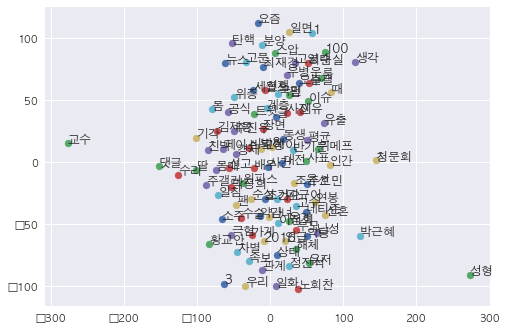

In [15]:
# getting a list of word vectors. limit to 100. each is of 100 dimensions
word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab.keys()]
word_vectors = list(word_vectors)[:100]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:100]

import matplotlib
matplotlib.rc('font', family='AppleGothic')

i = 0
for i in range(tsne_df['words'].size):
    plt.scatter(tsne_df['x'][i], tsne_df['y'][i])
    plt.annotate(tsne_df['words'][i],
                 xy=(tsne_df['x'][i],tsne_df['y'][i]))

plt.show()

t-SNE의 값은 PCA와 달리 지나치게 랜덤하게 바껴서 올바른 현상인지 확인이 필요하다.

In [16]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=2)
matrix = vectorizer.fit_transform([x.words for x in x_train])
matrix.shape


building tf-idf matrix ...


(5285, 2591)

In [17]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 2591


In [18]:
tfidf['문재인']

5.0730074248339694

In [19]:
tfidf['박근혜']

4.6099724649043274

In [20]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [21]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in map(lambda x: x.words, x_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in map(lambda x: x.words, x_test)])
test_vecs_w2v = scale(test_vecs_w2v)

train_vecs_w2v.shape

(5285, 200)

In [22]:
test_v = {}
test_tfidf = {}

test_v['A'] = np.array([0.1, 0.4])
test_v['B'] = np.array([0.2, 0.3])
test_v['C'] = np.array([0.3, 0.9])

test_tfidf['A'] = 4
test_tfidf['B'] = 10
test_tfidf['C'] = 7

def testBuildWordVector(tokens, size):
    vec = np.zeros(size).reshape(1,size)
    count = 0.
    for word in tokens:
        # token에 해당하는 벡터에 tfidf 가중치 부여하여 합산
        vec += test_v[word].reshape(1,size) * test_tfidf[word]
        count += 1.

    # token 수 만큼 나누어 1 token 기준 벡터 값 추출
    vec /= count
    
    return vec
    # vec

# 각 벡터를 하나의 numpy array로 join
test_v = np.concatenate([testBuildWordVector(z, 2) for z in [['A', 'B', 'C'], ['C']]])
test_v

array([[ 1.5       ,  3.63333333],
       [ 2.1       ,  6.3       ]])

In [23]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=120, batch_size=32, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


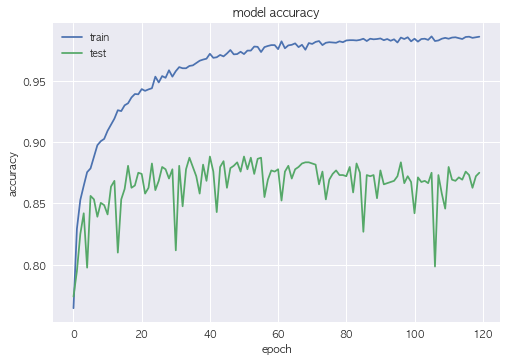

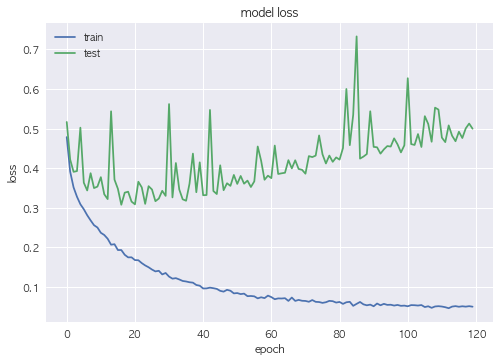

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
score # score[1] is accuracy

[0.54796073891211206, 0.89409984799268205]

In [26]:
train_vecs_w2v.shape

(5285, 200)

In [27]:
train_vecs_w2v = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
train_vecs_w2v.shape, y_train.shape

((5285, 200, 1), (5285,))

In [28]:
test_vecs_w2v = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)
test_vecs_w2v.shape

(1322, 200, 1)

In [29]:
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization

model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(128, 3,
                 input_shape=[200,1]))
# model.add(BatchNormalization())
model.add(Activation('relu'))

# GlobalMaxPooling1D를 했을때는 학습이 되지 않는 문제가 있음. accuracy 그래프가 올라가지 않는다.
# Flatten으로 변경 후 잘 올라가는데, 확인 필요.
# model.add(GlobalMaxPooling1D())
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25344)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1622080   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
__________

In [30]:
history = model.fit(train_vecs_w2v, y_train,
          batch_size=32,
          epochs=50,
          verbose=0,
          validation_data=(test_vecs_w2v, y_test),
          callbacks=[TQDMNotebookCallback(show_inner=False)])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


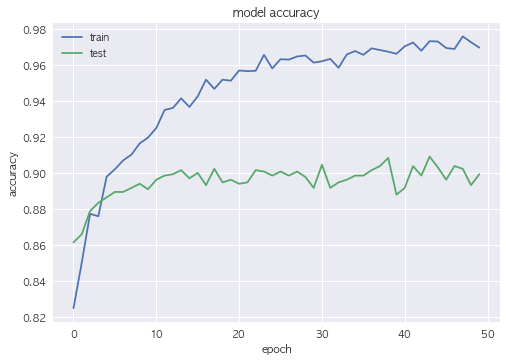

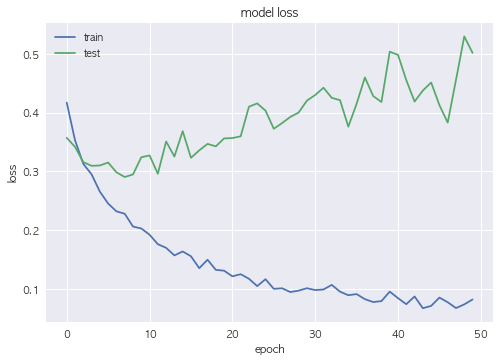

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
score # score[1] is accuracy

[0.50153496004810127, 0.89939485645871298]

In [33]:
model.metrics_names

['loss', 'acc']